In [1]:
from ase.io import read
import numpy as np
from matplotlib import pyplot as plt
import joblib, pickle, sys
sys.path.insert(0,"../")
from castle import train_ensamble_linear_model, train_linear_model, ASEMLCalculator, AceGlobalRepresentation, AceLocalRepresentation
from castle import get_forces_and_energies, get_virials, get_nat, dump, load, print_score, utils
rcuts = {'Cu': 3.9, 'Mo': 5.2, 'Si': 4.7, 'Ge':5.1, 'Ni':4.0, 'Li':5.1}

%load_ext autoreload
%autoreload 2

In [40]:
species = 'Si'
N = 5
maxdeg = 8
rcut = rcuts[species]
force_name = 'dft_force'
energy_name = 'dft_energy'
noise = 1e-8

root = f"/home/claudio/postdoc/data/Si_gabor/"

# tr_features, val_features = utils.extract_features(root, "train.xyz", "test.xyz",
#                                              N=N, maxdeg=maxdeg, rcut=rcut, force_name = force_name, energy_name =energy_name,
#                                             species = species)

e_t, f_t, e_val, f_val, nat_tr, nat_val, tr_features, val_features = utils.load_everything(
    root, "train.xyz", "test.xyz",
    f"tr_features_N_{N}_d_{maxdeg}_cut_{rcut}.xz", f"val_features_N_{N}_d_{maxdeg}_cut_{rcut}.xz",
    force_name = force_name, energy_name =energy_name)

CPU times: user 11.1 ms, sys: 31.9 ms, total: 43 ms
Wall time: 5.48 ms
MAE=0.030 RMSE=0.083 SUP=1.045 R2=0.986
MAE=0.136 RMSE=0.207 SUP=5.991 R2=0.938


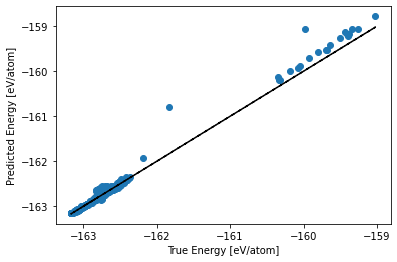

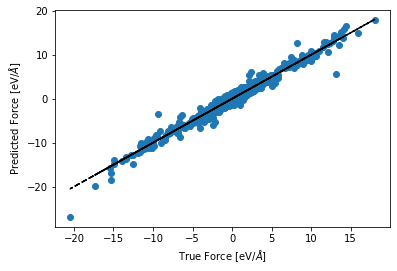

In [68]:
model = train_linear_model(tr_features, noise, e_t, f_t)

# evaluate its performances
%time ep, fp = model.predict(val_features)

print_score(ep/nat_val, e_val/nat_val)
print_score(fp.flatten(), f_val.flatten())

plt.scatter(e_val/nat_val, ep/nat_val)
plt.plot(e_val/nat_val, e_val/nat_val, 'k--')
plt.xlabel("True Energy [eV/atom]")
plt.ylabel("Predicted Energy [eV/atom]")
plt.show()

plt.scatter(f_val, fp)
plt.plot(f_val, f_val, 'k--')
plt.xlabel("True Force [eV/$\AA$]")
plt.ylabel("Predicted Force [eV/$\AA$]")
plt.show()

CPU times: user 1.39 s, sys: 683 ms, total: 2.07 s
Wall time: 1.26 s
MAE=0.297 RMSE=0.629 SUP=0.342 R2=-39.553
MAE=0.132 RMSE=0.214 SUP=2.916 R2=0.935


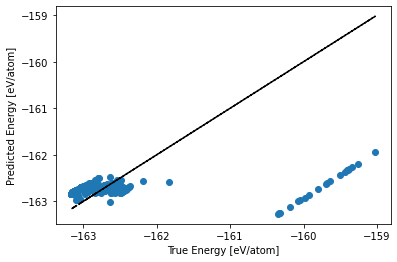

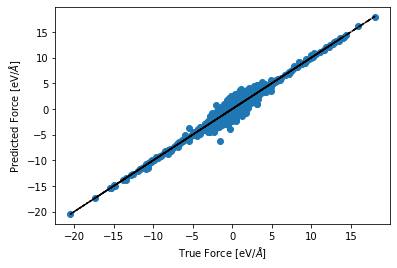

In [71]:
n_clusters = 20
# train the model
model =  train_ensamble_linear_model(tr_features, noise, e_t, f_t,
                         n_clusters=n_clusters, clustering='e_gmm')

# evaluate its performances
%time ep, fp = model.predict(val_features)
print_score(ep/nat_val, e_val/nat_val)
print_score(fp.flatten(), f_val.flatten())

plt.scatter(e_val/nat_val, ep/nat_val)
plt.plot(e_val/nat_val, e_val/nat_val, 'k--')
plt.xlabel("True Energy [eV/atom]")
plt.ylabel("Predicted Energy [eV/atom]")
plt.show()

plt.scatter(f_val, fp)
plt.plot(f_val, f_val, 'k--')
plt.xlabel("True Force [eV/$\AA$]")
plt.ylabel("Predicted Force [eV/$\AA$]")
plt.show()